Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [475]:
from random import random, seed
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from itertools import accumulate
from collections import deque

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [476]:
UNIVERSE_SIZE = 1000
NUM_SETS = 100
DENSITY = 0.2
MAX_STEPS = 10_000

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [477]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.power(SETS.sum(axis=1), 1.1)

## Helper Functions

In [478]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Professor's solutions

In [479]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(True, 33849.330206312516)

In [480]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(True, 15767.41704895838)

In [481]:
def fitness(solution: np.ndarray):
    """Returns the fitness of a solution"""
    return valid(solution), -cost(solution)  # I want a valid solution that minimizes the cost


def single_mutation(solution: np.ndarray) -> np.ndarray:
	new_sol = solution.copy()
	i = rng.integers(0, NUM_SETS)
	new_sol[i] = not new_sol[i]
	return new_sol


def multiple_mutation(solution: np.ndarray) -> np.ndarray:
	mask = rng.random (NUM_SETS) < 0.01
	new_sol = np.logical_xor(solution, mask)
	return new_sol

In [482]:
def plot(fitnesses):
    """Scatter plot of costs, and a line plot of the best cost"""
    steps = list(range(len(fitnesses)))
    plt.figure(figsize=(8, 4))
    plt.scatter(steps, fitnesses, label='Fitness', s=5)
    plt.plot(steps, list(accumulate(fitnesses, max)), label='Best fitness', color='red')
    plt.xlabel('Steps')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid()
    plt.show()

Initial fitness: (True, -33849.330206312516)
Final fitness: (True, -6301.671623742481)


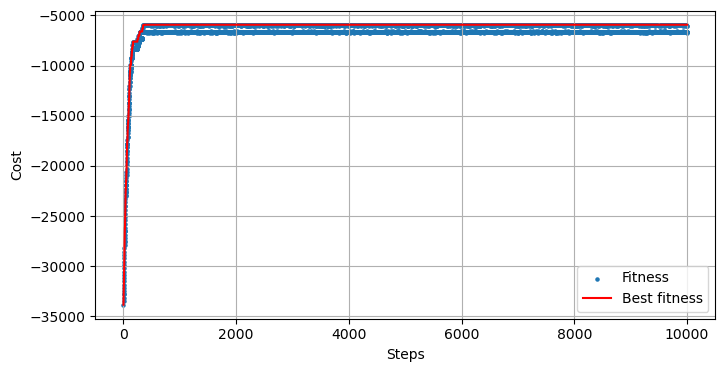

In [483]:
# First solution: RMHC with single mutation

solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]]
print(f"Initial fitness: {solution_fitness}")

tweak = single_mutation

for steps in range (MAX_STEPS):
	new_solution = tweak(solution)
	f = fitness(new_solution)
	history.append(f[1])
	
	if f > solution_fitness:
		solution = new_solution
		solution_fitness = f
		
print(f"Final fitness: {fitness(solution)}")
plot(history)

Initial fitness: (True, -33849.330206312516)
Final fitness: (True, -6560.842031945863)


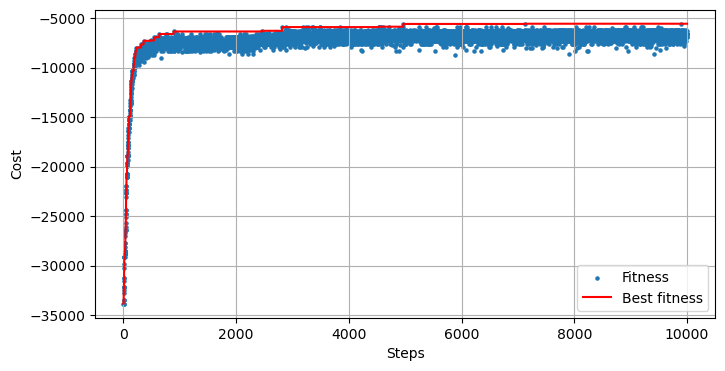

In [484]:
# Second solution: RMHC with multiple mutation

solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]]
print(f"Initial fitness: {solution_fitness}")

tweak = multiple_mutation

for steps in range (MAX_STEPS):
	new_solution = tweak(solution)
	f = fitness(new_solution)
	history.append(f[1])
	
	if f > solution_fitness:
		solution = new_solution
		solution_fitness = f
		
print(f"Final fitness: {fitness(solution)}")
plot(history)

## My solutions

## Solution 1: Simulated Annealing

Simulated Annealing explores the solution space by probabilistically accepting worse solutions to escape local optima; it gradually reduce the acceptance probability (temperature) as the search progresses, using the cooling_rate.

Initial fitness: (True, -19989.95607335359)
Final fitness: (True, -7057.09950814646)


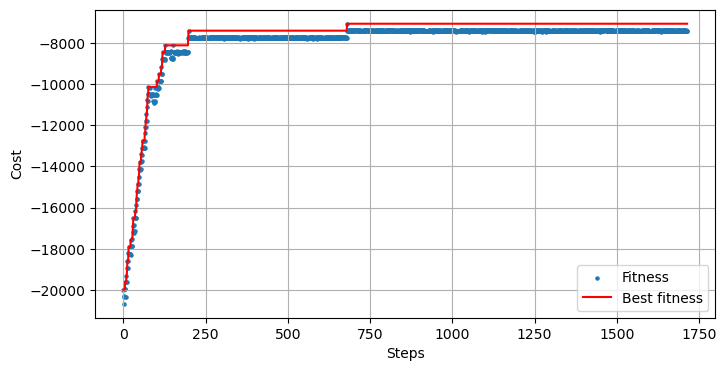

In [485]:
# Simulated Annealing 
def simulated_annealing(initial_solution, initial_temp=300, cooling_rate=0.99):
    solution = initial_solution
    solution_fitness = fitness(solution)
    
    temp = initial_temp
    history = [solution_fitness[1]]  # Track fitness history (not cost)
    print(f"Initial fitness: {solution_fitness}")
    
    for _ in range(MAX_STEPS):
        # Generate a new solution
        new_solution = tweak(solution)
        
        # Skip invalid solutions
        if not valid(new_solution):
            continue
        
        new_fitness = fitness(new_solution)

        # Record the current fitness in the history
        history.append(new_fitness[1])
        
        # Calculate the fitness difference (delta_fitness)
        delta_fitness = new_fitness[1] - solution_fitness[1]
        
        # Acceptance criterion: accept if the new solution has better fitness, or probabilistically if worse
        if delta_fitness > 0 or random() < np.exp(delta_fitness / temp):
            solution = new_solution
            solution_fitness = new_fitness
        
        # Cool down the temperature
        temp *= cooling_rate
        
        # Terminate if the temperature is too low
        if temp < 1e-5:
            break
    
    return solution, history


# Run the Simulated Annealing algorithm
tweak = single_mutation
initial_solution = rng.random(NUM_SETS) < 0.5 # Initialize a random solution
final_solution, history = simulated_annealing(initial_solution)
print(f"Final fitness: {fitness(final_solution)}")
plot(history)


## Solution 2: Tabu search


Tabu Search maintains a tabu list of recently explored solutions to prevent cycling back to them. It explores neighboring solutions and aims to select the best neighbor based on fitness. In my implementation, I generate 10 neighbor solutions and select the best one based on its fitness value.

Final fitness: (True, -6279.372232605605)


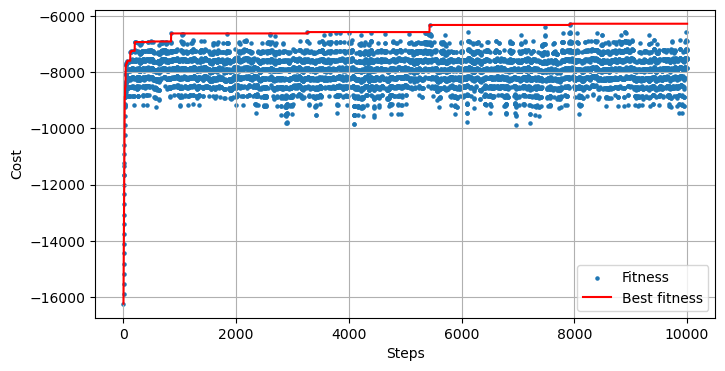

In [486]:
# Tabu Search 
def tabu_search(initial_solution, tabu_size=50):
    
    solution = initial_solution
    solution_fitness = fitness(solution)
    
    best_solution = solution
    best_fitness = solution_fitness
    
    # Tabu list to store recent solutions or moves
    tabu_list = deque(maxlen=tabu_size)
    tabu_list.append(solution.copy().tolist())  
    
    history = [solution_fitness[1]] 

    for _ in range(MAX_STEPS):
        # Generate 10 neighbor solutions
        neighborhood = [tweak(solution) for _ in range(10)]  
        
        # Filter out solutions that are in the tabu list and check if they are valid
        valid_neighbors = [n for n in neighborhood if valid(n) and n.tolist() not in tabu_list]
        
        if not valid_neighbors:
            # If no valid neighbors (that are not in the tabu list), skip to next iteration
            continue
        
        # Evaluate fitness of each valid neighbor
        neighbor_fitness = [fitness(n) for n in valid_neighbors]
        
        # Select the best neighbor solution (maximize fitness, i.e., minimize cost)
        best_neighbor_index = np.argmax([f[1] for f in neighbor_fitness])
        best_neighbor = valid_neighbors[best_neighbor_index]
        best_neighbor_fitness = neighbor_fitness[best_neighbor_index]
        
        # Update the current solution
        solution = best_neighbor
        solution_fitness = best_neighbor_fitness
        
        # Add the new solution to the tabu list
        tabu_list.append(solution.copy().tolist())
        
        # Update the global best solution if the current one is better
        if solution_fitness[1] > best_fitness[1]:
            best_solution = solution
            best_fitness = solution_fitness
        
        # Track fitness history
        history.append(solution_fitness[1])
        
    return best_solution, history


# Run the Tabu Search algorithm
initial_solution = rng.random(NUM_SETS) < 0.5 # Initialize a random solution
final_solution, history = tabu_search(initial_solution)
print(f"Final fitness: {fitness(final_solution)}")
plot(history)
